In [1]:
# 凸性在优化算法的设计中起到至关重要的作用，这主要是由于这种情况下对算法进行分析和测试要容易。换言之，如果算法在凸性条件设定下的效果很差，那通常我们很难在其他条件下看到好的结果。此外，即使深度学习中的优化问题通常是非凸的，它们也经常在局部极小值附近表现出一些凸性。

In [2]:
%matplotlib inline
import numpy as np
import torch
from mpl_toolkits import mplot3d
from d2l import torch as d2l

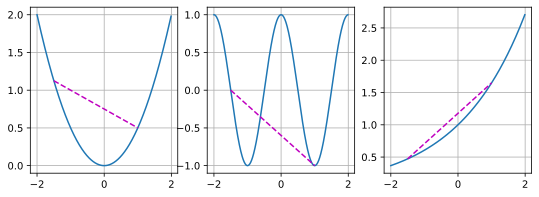

In [3]:
# 凸函数
f = lambda x: 0.5 * x **2  # 凸函数
g = lambda x: np.cos(np.pi*x)  # 非凸函数
h = lambda x: np.exp(0.5*x)  # 凸函数
x, segment = np.arange(-2, 2, 0.01), np.array([-1.5, 1])
d2l.use_svg_display()
_, axes = d2l.plt.subplots(1, 3, figsize=(9, 3))
for ax, func in zip(axes, [f, g, h]):
    d2l.plot([x, segment], [func(x), func(segment)], axes=ax)

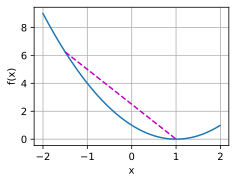

In [4]:
f = lambda x: (x - 1) ** 2
d2l.set_figsize()
d2l.plot([x, segment], [f(x), f(segment)], 'x', 'f(x)')
# 凸函数的局部极小值是全局极小值

In [6]:
%matplotlib inline
import numpy as np
import torch
from d2l import torch as d2l

def f(x):  # 目标函数
    return x**2
def f_grad(x):  # 目标函数的梯度（导数）
    return 2 * x

In [7]:
# 接下来，我们使用x=10作为初始值，并假设step=0.2,使用梯度下降法迭代x共十次，我们可以看到，x的值最终将接近最优解

In [8]:
def gd(eta, f_grad):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x)
        results.append(float(x))
    print(f'epoch 10 x: {x:f}')
    return results
results = gd(0.2, f_grad)

epoch 10 x: 0.060466


In [9]:
# 对进行x优化的过程可以绘制如下。
def show_trace(results, f):
    n = max(abs(min(results)), abs(max(results)))
    f_line = torch.arange(-n, n, 0.01)
    d2l.set_figsize()
    d2l.plot([f_line, results], [[f(x) for x in f_line], [f(x) for x in results]], 'x', 'f(x)', fmts=['-', '-o'])

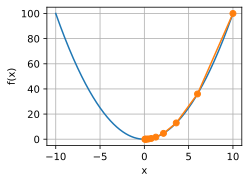

In [10]:
show_trace(results, f)

In [11]:
results

[10.0,
 6.0,
 3.5999999999999996,
 2.1599999999999997,
 1.2959999999999998,
 0.7775999999999998,
 0.46655999999999986,
 0.2799359999999999,
 0.16796159999999993,
 0.10077695999999996,
 0.06046617599999997]

epoch 10 x: 3.486784


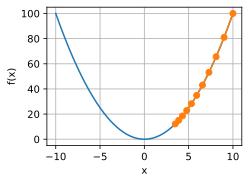

In [12]:
# 学习率
# 学习率决定目标函数能够收敛到局部最小值，以及何时收敛到最小值，学习率lr可由算法设计者设置。请注意，如果我们使用的学习率太小，将导致x的更新非常缓慢，需要更多的迭代。例如，考虑同一优化问题中step=0.05的进度。如下琐事，尽管经过了10个步骤，我们仍然离最优解很远。
show_trace(gd(0.05, f_grad), f)

epoch 10 x: 61.917364


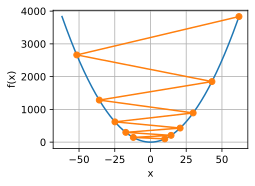

In [13]:
# 相反，如果我们使用过高的学习率，x超出了最优解，x=0并逐渐发散。
show_trace(gd(1.1, f_grad), f)

epoch 10 x: -1.528166


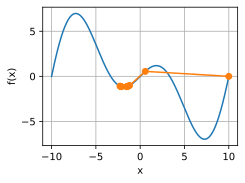

In [14]:
# 为了演示非凸函数的梯度下降，考虑函数f(x)=x*cos(cx),其中c为某常数。这个函数有无穷多个局部最小值，根据我们选择的学习率，我们最终可能只会得到许多解的一个。下面的例子说明了，高学习率如何导致较差的局部最小值
c = torch.tensor(0.15*np.pi)
def f(x):  # 目标函数
    return x*torch.cos(c*x)
def f_grad(x):  # 目标函数的梯度
    return torch.cos(c*x)-c*x*torch.sin(c*x)
show_trace(gd(2, f_grad), f)

In [22]:
# 多元梯度下降
def train_2d(trainer, steps=20, f_grad=None):
    """用定制的训练机优化2D目标函数"""
    # S1和S2是稍后将使用的内部状态变量
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 - trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f'epoch {i+1}, x1: {float(x1):f}, x2:{float(x2):f}')
    return results

def show_trace_2d(f, results):
    """显示优化过程中2D变量的轨迹"""
    d2l.set_figsize()
    d2l.plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = torch.meshgrid(torch.arange(-5.5, 1.0, 0.1),
                            torch.arange(-3.0, 1.0, 0.1))
    # 等高线图
    d2l.plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

epoch 20, x1: -0.057646, x2:-0.000073


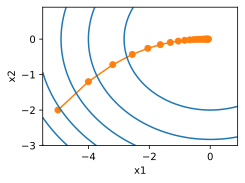

In [23]:
def f_2d(x1, x2):  # 目标函数
    return x1 ** 2 + 2 * x2 ** 2

def f_2d_grad(x1, x2):  # 目标函数的梯度
    return (2 * x1, 4 * x2)

def gd_2d(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    return (x1 - eta * g1, x2 - eta * g2, 0, 0)

eta = 0.1
show_trace_2d(f_2d, train_2d(gd_2d, f_grad=f_2d_grad))